#Introduction to the DM AFW packages
#### Written by Chris Walter of Duke University for the LSST Dark Energy Science Collaboration. Last Updated 5/2015 by Will Dawson using LSST Stack v10_0.

This IPython notebook is an introduction to the LSST DM stack with a focus on the AFW (applications framework) package used for dealing with image data.

Don't forget to the load LSST setup files and then "setup" before you start.
For this notebook running 'setup pipe_tasks' should load what you need. So before runing `ipython notebook` run the following in the terminal:

```
cd \path\to\lsst\
source loadLSST.bash
setup pipe_tasks -T v10_0
ipython notebook
```

If you followed the default LSST DM pipeline installation instructions then \path\to\lsst\ is ~\lsst. Change the suffix of the `source loadLSST.bash` command to match your shell.

Start by importing the packages we are going to use.

In [1]:
import lsst.afw.math        as math
import lsst.afw.table       as afwTable
import lsst.afw.image       as afwImg
import lsst.afw.detection   as afwDetect
import lsst.meas.algorithms as measAlg

%matplotlib inline
from matplotlib.colors  import LogNorm
import matplotlib.pyplot as plt

## Exposure Creation and Exploration
Now create an exposure by reading a PhoSim output file (you should have created this seperately and copied the eimage file to somewhere you can use it).  A exposure contains a MaskedImage (image, mask and variance image), Meta-data and optional WCS and PSF information. The mask and variances will be empty. The Psf returns nothing now.

In [2]:
exposure    = afwImg.ExposureF('lsst_e_99999999_f2_R22_S11_E000.fits.gz')

maskedImage = exposure.getMaskedImage()

# These three are held in the maskedImage
image       = maskedImage.getImage()
mask        = maskedImage.getMask()
variance    = maskedImage.getVariance()

wcs         = exposure.getWcs()
metaData    = exposure.getMetadata()
psf         = exposure.getPsf()

Plot the CCD data (there should be a star in the middle) and also print out the mask and variance data.

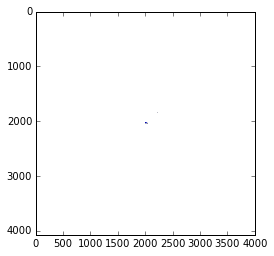

In [4]:
plt.imshow(image.getArray(),norm=LogNorm());

In [5]:
mask.getArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [6]:
variance.getArray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

Printout the WCS and FITS Header metaData keys.

In [7]:
metaWCS = wcs.getFitsMetadata()
metaWCS.getOrderedNames()        #print them out

('NAXIS',
 'EQUINOX',
 'RADESYS',
 'CRPIX1',
 'CRPIX2',
 'CD1_1',
 'CD1_2',
 'CD2_1',
 'CD2_2',
 'CRVAL1',
 'CRVAL2',
 'CUNIT1',
 'CUNIT2',
 'CTYPE1',
 'CTYPE2')

In [8]:
print "There are ", metaData.nameCount(), "items."
print "The first 20 names are", metaData.names()[:20]

There are  322 items.
The first 20 names are ('VERSION', 'CREATOR', 'QEVAR', 'OVRDEP', 'SF', 'NB', 'NBULK', 'CHPANG', 'MAXY', 'MINY', 'MAXX', 'MINX', 'FPFILE', 'NF', 'PAIRID', 'PIXSIZE', 'DOMESEE', 'LASCPR', 'AERIND', 'H2OPRESS')


Let's retrieve one of the header members and see who made this FITS file.

In [9]:
print metaData.get('CREATOR')

PHOSIM


### Statistics without a mask
Now let's look at statistics of the image.  In a bit we will see what using a mask can do.  First set up the statistics flag:

In [10]:
statFlags = math.NPOINT | math.MEAN | math.STDEV | math.MAX | math.MIN | math.ERRORS
print "The statistics flags are set to %s."%bin(statFlags)
print "Errors will be calculated."

The statistics flags are set to 0b110000001111.
Errors will be calculated.


First let's set individual pixel (0,0) to 65,000.  This will saturate a single pixel and screw up our overall statitics.  Later we will see how to mask it out.

In [11]:
image.set(0, 0, 65000)

*VERY IMPORTANT*: If you want to use a mask, you need to make a control object and tell the statistics routines which planes to pay attention to.  Also: unlike what is says in some documentation 0 will *ignore* all of the mask layers not use all of them. Here I will tell AFW to use the saturation (SAT) plane. Note I have't actually set any saturated bits yet.  I will do that later.

In [12]:
control = math.StatisticsControl()
SAT = afwImg.MaskU_getPlaneBitMask("SAT")
control.setAndMask(SAT);        #pixels with this mask bit set will be ignored.

Now let's do the statistics on the sensor.  The saturated pixel will screw things up.

In [13]:
imageStatistics = math.makeStatistics(maskedImage, statFlags, control)
numBins         = imageStatistics.getResult(math.NPOINT)[0]
mean            = imageStatistics.getResult(math.MEAN)[0]

print "The image has dimensions %i x %i pixels" %(maskedImage.getWidth(), maskedImage.getHeight())
print "Number of analyzed bins in image is %i"  %numBins
print "Max    = %9d"                            %imageStatistics.getResult(math.MAX)[0]
print "Min    = %9d"                            %imageStatistics.getResult(math.MIN)[0]
print "Mean   = %9.8f +- %3.1f"                 %imageStatistics.getResult(math.MEAN)
print "StdDev = %9.2f"                          %imageStatistics.getResult(math.STDEV)[0]

The image has dimensions 4000 x 4072 pixels
Number of analyzed bins in image is 16288000
Max    =     65000
Min    =         0
Mean   = 0.00555734 +- 0.0
StdDev =     16.13


### Statistics with a mask
Now also set the mask bit to SAT (Saturated) for that pixel. This should cause the builtin statistics routines to igrore this pixel as earlier we told them to pay attention to the SAT mask layer.

In [14]:
saturationBit = mask.getPlaneBitMask('SAT')
mask.set (0, 0, saturationBit)

Now the let's try the same thing again.

In [15]:
imageStatistics = math.makeStatistics(maskedImage, statFlags, control)
numBins         = imageStatistics.getResult(math.NPOINT)[0]
mean            = imageStatistics.getResult(math.MEAN)[0]

print "The image has dimensions %i x %i pixels" %(maskedImage.getWidth(), maskedImage.getHeight())
print "Number of analyzed bins in image is %i"  %numBins
print "Max    = %9d"                            %imageStatistics.getResult(math.MAX)[0]
print "Min    = %9d"                            %imageStatistics.getResult(math.MIN)[0]
print "Mean   = %9.8f +- %3.1f"                 %imageStatistics.getResult(math.MEAN)
print "StdDev = %9.2f"                          %imageStatistics.getResult(math.STDEV)[0]


The image has dimensions 4000 x 4072 pixels
Number of analyzed bins in image is 16287999
Max    =      1103
Min    =         0
Mean   = 0.00156667 +- 0.0
StdDev =      0.87


As we can see one less pixel was considered and now the saturated pixel was ignored.

## Source Detection
Now let's try to find the peak.  No backgound subtraction will be done because there is no background in this simulated image. This first step finds a "footprint" of connected pixels including its center. 

I am going to start by running these algorithms for detection and measurment "manually" so we can see the proper way to call them.  Later I will call routines that will call them for me.

In [16]:
thresholdValue = 50
npixMin        = 5 
grow           = 1
isotropic      = False

threshold = afwDetect.Threshold(thresholdValue, afwDetect.Threshold.VALUE)
footPrintSet  = afwDetect.FootprintSet(maskedImage, threshold, "DETECTED", npixMin)
footPrintSet  = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

footPrints = footPrintSet.getFootprints()

footPrintSet.setMask(maskedImage.getMask(), "DETECTED")

Now, let's print out the peak we found.

In [17]:
print "I found ", footPrints.size(), "footPrint(s)"
print

for i in range(0,footPrints.size()):
    print "Footprint:",i
    
    peak = footPrints[i].getPeaks()[0]
    print "A peak of value", peak.getPeakValue()
    print "was found at X =", peak.getFx(),"Y =",peak.getFy()


I found  1 footPrint(s)

Footprint: 0
A peak of value 1103.0
was found at X = 2000.0 Y = 2032.0


We found our star!

## Source Measurement
Now let's take that peak and try to measure it with one of the alogorithms.  We will use some of the infrastructure and also reduce the list of algorithms to apply to only one.  

To do this I will also reset some "aliases" so that they don't point to algorithms that we aren't going to use (the default code uses several).  The aliases are pointers into records in the output table. The names of these pointers are independent of the algorithms.  So I can point them at the alogorithm results I want and then just ask for an output variable through an access function and it will get the correct one. This way, you can switch which algorithm generates the output, but not change how you access the answer.

Note: This example uses tables and catalogs.  If you don't understand those you should also look at the short notebook which introduces them.

In [18]:
# Make a Schema which is a list of columns for a table.  The object below store things in a table. 
# The Schema is a describption of what is in each column. It can be added to by algorithms later.
schema = afwTable.SourceTable.makeMinimalSchema()

# Make an object which we are going to use to configure the algorithms
# Decide which algorithms to include (meas_algorithms/../tests/measure.py) is a good reference
# Note: the pre-centroid fit is set seperately (it is set by default to 'centroid.sdss')
measureSourcesConfig                  = measAlg.SourceMeasurementConfig()

measureSourcesConfig.algorithms.names = ['shape.sdss']

#Aliases only
measureSourcesConfig.slots.psfFlux    = None
measureSourcesConfig.slots.apFlux     = None
measureSourcesConfig.slots.modelFlux  = None
measureSourcesConfig.slots.instFlux   = None
measureSourcesConfig.validate()

# Now make the object which includes list the algorithms we want to use
# using the measureSourcesConfig object I made before.
# It also adds output places for those algorithms to the schema.
# This object can apply it's algorithms to images given a list of sources.
measureSources = measureSourcesConfig.makeMeasureSources(schema)

# First make a catalog. Then, setup the aliases in the table so that it agrees with 
# our rules above (where we set the aliases to None).
catalog  = afwTable.SourceCatalog(schema)
measureSourcesConfig.slots.setupTable(catalog.getTable())

# Take the set of footPrints (areas around the detected objects) we found when 
# we did the detection and then put them in the catalog.
footPrintSet.makeSources(catalog)

# Loop over all of the sources in the catalog.  For each source apply our measurement algorithms to it.
# It uses the data in the exposure for the calculation.  After the algorithim is run, print the centroid
# of the source as found by the algorithm.  We access it throgh an alias.
for i, source in enumerate(catalog):
    print i
    measureSources.apply(source, exposure)
    print source.getCentroid()

0
(1999.5, 2032.5)


## Source Detection and Measurement (the effecient coding way)
Now let's do both steps again (detection and measurement) in a simpler way.  We will use the tasks that were setup to help us do these jobs.  This is the recomended interface. Internally it is doing a lot of what we did in the previous examples but being more comprehensive. We can configure them how we want.  Doing it this way is more compact, flexible and it is easier to understand since the steps pretty much make sense. BTW, you can still restrict the algorithms as I showed above etc in the same way. Here I use all of the default algorithms.

In [22]:
# Configure the detection and measurement algorithms
schema                = afwTable.SourceTable.makeMinimalSchema()
detectSourcesConfig   = measAlg.SourceDetectionConfig(thresholdType='value')
measureSourcesConfig  = measAlg.SourceMeasurementConfig()

# Setup the detection and measurement tasks
detect  = measAlg.SourceDetectionTask  (config=detectSourcesConfig,  schema=schema)
measure = measAlg.SourceMeasurementTask(config=measureSourcesConfig, schema=schema)

# Set flux aliases to None; a hack for an incompatability between makeMinimalSchema() and the
# default SourceMeasurementConfig() options.
measureSourcesConfig.slots.psfFlux    = None
measureSourcesConfig.slots.apFlux     = None
measureSourcesConfig.slots.modelFlux  = None
measureSourcesConfig.slots.instFlux   = None
measureSourcesConfig.validate()

# Detect the sources,then put them into a catalog (the table is where the catalog atually stores stuff)
table   = afwTable.SourceTable.make(schema)
catalog = detect.makeSourceCatalog(table, exposure, sigma=5)

# Get the sources out of the catalog
sources = catalog.sources

# Apply the measurement routines to the exposure using the sources as input
measure.run(exposure, sources)

# Now let's look at the output from some of the measurment algorithms.
fields = ['centroid.sdss', 'shape.sdss', 'shape.sdss.centroid','flux.gaussian']
keys   = [schema.find(f).key for f in fields]

for source in sources:
    print source.getCentroid() #This uses one of the aliases

    # Now loop through the keys we want
    for f,k in zip(fields, keys):
        print '    ', f, source.get(k)

(1999.5, 2032.5)
     centroid.sdss (1999.5, 2032.5)
     shape.sdss (ixx=2.88751926897, iyy=3.05814257946, ixy=-0.133327694904)
     shape.sdss.centroid (1999.5, 2032.5)
     flux.gaussian 21410.8483803


We can also use the DS9 program to display our results.  This will overlay the footprint and the source measured centroid to the sensor data. This is commented out by default in case you don't have ds9 installed.

In [25]:
#import lsst.afw.display.ds9 as ds9
##ds9.setMaskPlaneVisibility("DETECTED",False)
#ds9.setMaskTransparency(75)

#ds9.mtv(maskedImage)
#ds9.dot("+", source.getX(), source.getY())

Next we can take the code in this tutorial and turn it into a single program.  Then, we can learn how to make it into a commandLine Task and use some framework code that will take care of some more things I did in the last step for us automatically.  I do that in the next notebook.